In [1]:
# Install and import libraries
!pip install pandas xlwings
import pandas as pd
import math
import numpy as np
from scipy.optimize import curve_fit
from scipy.optimize._numdiff import approx_derivative

In [3]:
# Data import
file_path = "/Users/elchulito/Library/CloudStorage/OneDrive-polymtlus/0 - A_Database and methodology_PhD/PlasticFADE.xlsx"
sheet_name = "DS_Calibration"
data_frag = pd.read_excel(file_path, sheet_name=sheet_name, usecols="A,D:G", skiprows=1)
data_frag = data_frag[data_frag.iloc[:, 0].str.contains("F-PP-", na=False)]
# data_frag = data_frag.drop(index=6)  # Manually remove the invalid data point (when necessary)
print(data_frag)

# Known variables
k_frag_i_j = data_frag.iloc[:, 1].values
s = data_frag.iloc[:, 2].values
I_j = data_frag.iloc[:, 3].values
P_j = data_frag.iloc[:, 4].values
print(I_j)

'''
a_i, delta_i, b_i, alpha_i, c_i, beta_i (float): Empirical constants for polymer i
s (float): Surface area to volume ratio [cm^-1]
I_j (float): UV intensity in compartment j [W/m^2]
P_j (float): Mechanical power that acts on the plastics in compartment j [mW]
k_frag_i_j (float): The calculated degradation rate constant [d^-1] for polymer i in compartment j
'''

    D.P.I.  k [i,j] [d-1]   s [cm-1]  I_j [W/m2]  P_j [mW]
0  F-PP-01   5.022636e-05  18.123118       11.17  0.000000
1  F-PP-02   2.202319e-08   5.511111       27.50  0.000000
2  F-PP-03   4.897751e-07  21.733333       27.50  0.000000
3  F-PP-04   5.007515e-05  18.123118        0.00  0.027774
4  F-PP-05   4.684603e-02  21.733333        0.00  0.296088
5  F-PP-06   4.000080e-05  42.000000        0.00  0.009870
6  F-PP-07   1.711408e-06  50.000000        0.00  0.000112
7  F-PP-08   4.848727e-06  50.000000        4.99  0.000112
8  F-PP-09   4.924158e-06  15.000000        1.65  0.000252
[11.17 27.5  27.5   0.    0.    0.    0.    4.99  1.65]


'\na_i, delta_i, b_i, alpha_i, c_i, beta_i (float): Empirical constants for polymer i\ns (float): Surface area to volume ratio [cm^-1]\nI_j (float): UV intensity in compartment j [W/m^2]\nP_j (float): Mechanical power that acts on the plastics in compartment j [mW]\nk_frag_i_j (float): The calculated degradation rate constant [d^-1] for polymer i in compartment j\n'

In [5]:
# Model definition (linear popt, log params_std)
def RC_frag(params, s, I_j, P_j):
    a_i, delta_i, b_i, alpha_i, c_i, beta_i = params
    return a_i * (s**delta_i) * (b_i * (I_j**alpha_i) + c_i * (P_j**beta_i))

# Log-space curve fitting (more suitable for rate constants spanning orders of magnitude)
def log_model_frag(inputs, a_i, delta_i, b_i, alpha_i, c_i, beta_i):
    s, I_j, P_j = inputs
    params = [a_i, delta_i, b_i, alpha_i, c_i, beta_i]
    k_frag = RC_frag(params, s, I_j, P_j)
    return np.log(k_frag)

# Prepare inputs (X) and outputs (Y) arrays
X = (s, I_j, P_j)
Y = np.log(k_frag_i_j)

# Fitting settings (Initial guesses, bounds, convergence threshold, maximum iterations)
initial_guess = [1, 1, 1, 1, 1, 1]
bounds = ([0]*6, [np.inf]*6) # Lower and upper bounds
tolerance = 0.001  # 0.1%
max_iterations = 1000

# The loop for iterations
for iteration in range(max_iterations):
    # Perform curve fitting (maxfev: maximum function evaluations, which is calculated as: maxfev=200×(number of parameters + 1)
    # Fit log-transformed model to log-transformed data
    popt, pcov = curve_fit(log_model_frag, X, Y, p0=initial_guess, bounds=bounds, maxfev=2000)
    # Calculate the relative difference
    relative_diff = np.abs(popt - initial_guess) / np.abs(initial_guess)
    # Update the initial guess
    initial_guess = popt
    # Check for convergence
    if np.all(relative_diff < tolerance):
        print(f"Converged after {iteration + 1} iterations.")
        break
else:
    print("Reached the maximum number of iterations without full convergence.")

# Fitted parameters (i.e., parameter estimates), in linear space
parameter_names = ['a_i', 'delta_i', 'b_i', 'alpha_i', 'c_i', 'beta_i']
for name, value in zip(parameter_names, popt):
    print(f"{name}: {value}")

Converged after 4 iterations.
a_i: 4.65659075018504e-06
delta_i: 2.25916693221392
b_i: 0.0005341273089696998
alpha_i: 4.999999999999983e-13
c_i: 8.67563198265117
beta_i: 1.4363331500021483


In [7]:
# Compute determination coefficient (R^2) while fully staying in log-space
# Step 1: Compute log-observed and log-predicted
eps = 1e-10  # Small constant to avoid log(0) issues
log_obs = np.log(k_frag_i_j + eps)  # Avoid log(0)
log_pred = log_model_frag(X, *popt)  # Already log(k_pred)


# Step 2: Compute SS_res and SS_tot in log-space
ss_res_log = np.sum((log_obs - log_pred)**2)
ss_tot_log = np.sum((log_obs - np.mean(log_obs))**2)

# Step 3: Compute R² in log-space
r_squared_log = 1 - (ss_res_log / ss_tot_log)
print(f"Log-space R² (pseudo-R²): {r_squared_log:.3f}")

Log-space R² (pseudo-R²): 0.770


In [9]:
# Save fitted parameters back to Excel (without modifying)
import xlwings as xw

# File path and sheet details
file_path = "/Users/elchulito/Library/CloudStorage/OneDrive-polymtlus/0 - A_Database and methodology_PhD/PlasticFADE.xlsx"
sheet_name = "Drop-down lists"
start_row = 7  # Change for other polymer types (4-13)
start_col = "C"

# Fitted parameters
fitted_parameters = popt

# Start the Excel application and open the workbook
app = xw.App(visible=True)  # Set visible=True to open the file automatically
workbook = app.books.open(file_path)
sheet = workbook.sheets[sheet_name]

# Write the fitted parameters to the specified cells
for i, value in enumerate(fitted_parameters):
    column = chr(ord(start_col) + i)
    cell = f"{column}{start_row}"
    sheet.range(cell).value = value

# Save the workbook
workbook.save()
workbook.close()
app.quit()

In [19]:
# Compute the Fisher Information Matrix (also fully in log-space)
from scipy.optimize._numdiff import approx_derivative

# Step 1: Define the wrapped model for Jacobian estimation
def wrapped_model(params):
    return log_model_frag(X, *params)

# Step 2: Compute residuals and estimated variance
residuals = Y - wrapped_model(popt)  # log of observed data (Y) - log of model output
sigma2 = np.var(residuals, ddof=1)  # Change to ddof=len(popt) when the number of available data points >> empirical constants

# Step 3: Compute the Jacobian at fitted parameters (sensitivity matrix)
J = approx_derivative(wrapped_model, popt, method='cs')

# Step 4: Compute Fisher Information Matrix (round to 3 significant digits)
FIM = (1 / sigma2) * J.T @ J

# Step 5: Compute standard deviations from the inverse of FIM
# cov_est = np.linalg.inv(FIM)
cov_est = np.linalg.pinv(FIM) # Uses the Moore–Penrose pseudo-inverse to avoid numerical instability or singularity issues
param_std = np.sqrt(np.diag(cov_est))

# Step 6: Compute relative uncertainty (in linear space, with param_std back-transformed)
param_names = ['a_i', 'delta_i', 'b_i', 'alpha_i', 'c_i', 'beta_i']
relative_uncertainty = 100 * (np.abs(popt) * np.sqrt(np.expm1(param_std**2)) / np.abs(popt))  # Fixes the 0.00e+00 issue

# Format all values as strings with 3 significant digits ---
summary_df = pd.DataFrame({
    'Parameter': param_names,
    'Estimate': popt,
    'Std. Dev (σ)': param_std,
    'Relative Uncertainty (%)': relative_uncertainty
})

# --- Output ---
pd.set_option('display.float_format', '{:.2e}'.format)
print("Inverse of Fisher Information Matrix (parameter covariance matrix):")
print(np.array2string(cov_est, formatter={'float_kind': lambda x: f"{x:.2e}"}))
print("\nStandard deviations of parameter estimates (Cramér–Rao bounds): See the table below")
print("📋 Relative Uncertainty Table:")
print(summary_df.to_string(index=False))
print("\nNumber of residuals:", len(residuals))

Inverse of Fisher Information Matrix (parameter covariance matrix):
[[3.42e-10 -2.02e-05 -2.47e-09 -4.98e-06 1.52e-13 8.95e-08]
 [-2.02e-05 1.52e+00 -4.23e-04 3.61e-01 2.60e-08 1.78e-01]
 [-2.47e-09 -4.23e-04 2.34e-06 -9.76e-04 -1.44e-10 -3.06e-04]
 [-4.98e-06 3.61e-01 -9.76e-04 8.12e-01 6.01e-08 2.69e-02]
 [1.52e-13 2.60e-08 -1.44e-10 6.01e-08 8.88e-15 1.88e-08]
 [8.95e-08 1.78e-01 -3.06e-04 2.69e-02 1.88e-08 1.35e-01]]

Standard deviations of parameter estimates (Cramér–Rao bounds): See the table below
📋 Relative Uncertainty Table:
Parameter  Estimate  Std. Dev (σ)  Relative Uncertainty (%)
      a_i  4.66e-06      1.85e-05                  1.85e-03
  delta_i  2.26e+00      1.23e+00                  1.89e+02
      b_i  5.34e-04      1.53e-03                  1.53e-01
  alpha_i  5.00e-13      9.01e-01                  1.12e+02
      c_i  8.68e+00      9.42e-08                  9.42e-06
   beta_i  1.44e+00      3.67e-01                  3.80e+01

Number of residuals: 9


In [14]:
# Save standard deviations and relative uncertainty of fitted parameters back to Excel (without modifying)
import xlwings as xw

cols_to_write = ['Estimate', 'Std. Dev (σ)', 'Relative Uncertainty (%)']
data_to_write = summary_df[cols_to_write].values.tolist()

wb = xw.Book('/Users/elchulito/Library/CloudStorage/OneDrive-polymtlus/0 - A_Database and methodology_PhD/PlasticFADE.xlsx')  # Use full path if not in working directory
ws = wb.sheets['Uncertainty']

start_cell = 'C39'  # Change this index for other polymers
ws.range(start_cell).value = data_to_write

wb.save()
wb.close()

    D.P.I. R.E.S. k_model [d-1] k [i,j] [d-1]
0  F-PP-01     UV      1.73e-06      5.02e-05
1  F-PP-02     UV      1.18e-07      2.20e-08
2  F-PP-03     UV      2.61e-06      4.90e-07
3  F-PP-04     MS      1.63e-04      5.01e-05
4  F-PP-05     MS      7.38e-03      4.68e-02
5  F-PP-06     MS      2.47e-04      4.00e-05
6  F-PP-07     MS      5.91e-07      1.71e-06
7  F-PP-08  UV+MS      1.77e-05      4.85e-06
8  F-PP-09  UV+MS      1.25e-06      4.92e-06


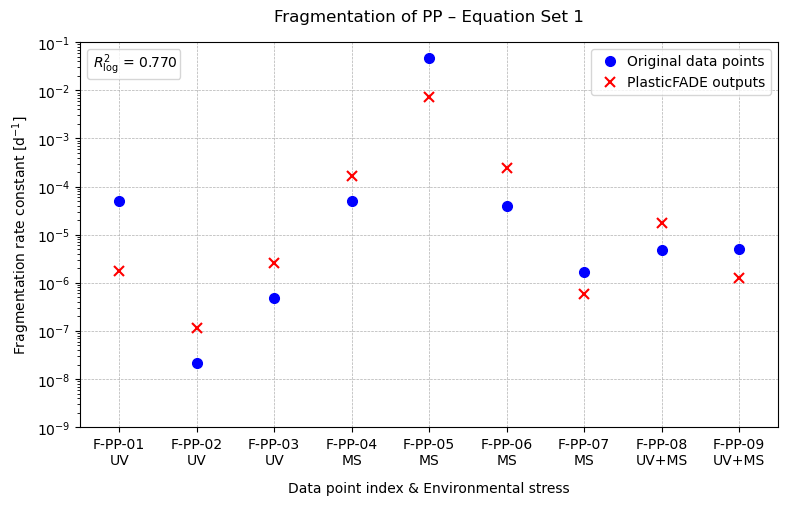

In [16]:
# Plot the modeling results with the original data points in the same graph
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Import the original data points and calculated RCs from PlasticFADE
import matplotlib.pyplot as plt
file_path = "/Users/elchulito/Library/CloudStorage/OneDrive-polymtlus/0 - A_Database and methodology_PhD/PlasticFADE.xlsx"
data_comp = pd.read_excel(file_path, sheet_name="Scatterplot", usecols="A:D", skiprows=5)
data_comp = data_comp[data_comp.iloc[:, 0].str.contains("F-PP-", na=False)]
pd.set_option('display.float_format', '{:.2e}'.format)
print(data_comp)

fig, ax = plt.subplots(figsize=(9, 5))
df = pd.DataFrame(data_comp)
df['x_labels'] = df['D.P.I.'] + '\n' + df['R.E.S.']

# Plot original data and model output
ax.plot(df['D.P.I.'], df['k [i,j] [d-1]'], 'bo', markersize=7, label='Original data points')
ax.plot(df['D.P.I.'], df['k_model [d-1]'], 'rx', markersize=7, markeredgewidth=1.5, label='PlasticFADE outputs')

# Main legend
main_legend = ax.legend(loc='upper right', handletextpad=0.2)
ax.add_artist(main_legend)  # keep it when adding another legend

# --- Create second legend entry for R² without marker ---
r2_label = f'$R_{{\\mathrm{{log}}}}^2$ = {r_squared_log:.3f}'

# Make an invisible Line2D object (no line, no marker)
empty_line = Line2D([], [], color='none')

# Add the second legend with zero padding before the text
r2_legend = ax.legend([empty_line], [r2_label], loc='upper left', frameon=True, handlelength=0, handletextpad=0.2, borderpad=0.2)

plt.xticks(df['D.P.I.'], df['x_labels'])
plt.xlim(-0.5, len(data_comp) - 0.5)
ax.set_xlabel('Data point index & Environmental stress', labelpad=10)
ax.set_ylabel('Fragmentation rate constant [d$^{-1}$]')
ax.set_yscale('log')
ax.set_ylim(1e-9, 1e-1)
ax.grid(True, which="major", ls="--", lw=0.5)
ax.set_title('Fragmentation of PP – Equation Set 1', pad=15)

plt.savefig("/Users/elchulito/F_PP_S1_final.png", dpi=600, bbox_inches='tight')
plt.show()